In [17]:
from platform import python_version
import tensorflow as tf

print(tf.test.is_gpu_available())
print(python_version())

True
3.7.5


In [18]:
import os
import numpy as np
from os import listdir
from PIL import Image
import time
import tensorflow as tf
from tensorflow.keras import layers,models,optimizers
from keras import backend as K
import matplotlib.pyplot as plt

In [19]:
path1="datasets/ofg_family/"
path2="datasets/TSKinFace_Data/TSKinFace_cropped/"

randomiser = np.random.RandomState(123)

In [20]:
img_size = 64
mean = 0.0009
std_dev = 0.009
lr = 0.0005
b1 = 0.875
b2 = 0.975
sd_random_normal_init = 0.02

EPOCHS = 10
batch = 10

In [21]:
def generate_image_1(family_dir):
    dic={}
    sub=[a for a in listdir(path1+"/"+family_dir)]
    
    for ele in sub:
        if ele == '.DS_Store':
            continue;
        mypath = path1+"/"+family_dir+"/"+ele+"/"
        onlyfiles = [mypath+f for f in listdir(mypath)]
        
        addr = randomiser.choice(onlyfiles)
        original_img = np.array(Image.open(addr).resize((64,64),Image.ANTIALIAS))
        if ele[0].lower()=='f':
            dic['father'] = original_img
        elif ele[0].lower()=='m':
            dic['mother'] = original_img
        elif ele.lower()=='child_male':
            dic['child'] = original_img    
            dic['gender']=np.zeros((original_img.shape))
        elif ele.lower()=='child_female':
            dic['child'] = original_img    
            dic['gender'] = np.ones((original_img.shape))
    return [dic['father'],dic['mother'],dic['gender'],dic['child']]

def generate_image_2(family_dir, family_number, gender):
    dic={}
    sub = ["F" , "M", gender]
    family_pth = path2+"/"+family_dir+"/" + family_dir + "-" + str(family_number) + "-"
    for ele in sub:
        addr = family_pth+ele+".jpg"
        original_img = np.array(Image.open(addr).resize((64,64),Image.ANTIALIAS))
        if ele =='F':
            dic['father'] = original_img
        elif ele == 'M':
            dic['mother'] = original_img
        elif ele == 'S':
            dic['child'] = original_img    
            dic['gender']=np.zeros((original_img.shape))
        elif ele == 'D':
            dic['child'] = original_img    
            dic['gender'] = np.ones((original_img.shape))
    return [dic['father'],dic['mother'],dic['gender'],dic['child']]

def generate_batch(families_batch):
    np_images=[]
    for family in families_batch:
        if(len(family) == 3):
            res = generate_image_2(family[0], family[1], family[2])
        elif(len(family) == 1):
            res = generate_image_1(family[0])
        if( res != None):
            np_images.append(res)
    
    return np_images

In [22]:
for r, d, f in os.walk(path1):
        all_families = d
        break      
all_families = [[family] for family in all_families] 

for i in range(285):
    all_families.append(['FMS', i+1, 'S'])
for i in range(274):
    all_families.append(['FMD', i+1, 'D'])
    
for i in range(228):
    all_families.append(['FMSD', i+1, 'D'])  
    all_families.append(['FMSD', i+1, 'S'])  


randomiser.shuffle(all_families)

train_families = all_families[:-100]
test_families = all_families[-100:]

In [23]:
OUTPUT_CHANNELS = 3

In [24]:
def gen_downsample_parent(filters, size, apply_batchnorm=True, apply_dropout=False):
    initializer = tf.random_normal_initializer(mean, std_dev) 
  

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer,
                             use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.ELU())
        
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(rate = 0.5))

    return result

In [25]:
def gen_upsample(filters, size,apply_batchnorm = False):
    initializer = tf.random_normal_initializer(mean, std_dev)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                   use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        result.add(tf.keras.layers.ELU())

    return result

In [26]:
def EncoderNN():
    down_stack_parent = [
    gen_downsample_parent(32,4,apply_batchnorm=True, apply_dropout=False),
    gen_downsample_parent(64,4,apply_batchnorm=True, apply_dropout=False)
    ]
    
#     down_stack_noise =[
# #   z = 4x4x64
#     gen_downsample_noise(64,4,apply_batchnorm=True), #8x8x64
#     gen_downsample_noise(32,4,apply_batchnorm=True) #16x16x32      
#     ]
    
    final_conv =[
        gen_upsample(32,4 ,apply_batchnorm = True)
    ]
    
    initializer = tf.random_normal_initializer(mean, sd_random_normal_init)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')

    concat = tf.keras.layers.Concatenate()

    father = tf.keras.layers.Input(shape=(img_size,img_size,3))
    mother = tf.keras.layers.Input(shape=(img_size,img_size,3))

    
    
    x1 = father
    for down in down_stack_parent:
        x1 = down(x1)
    
#     print(x1.shape)
    
    x2 = mother
    for down in down_stack_parent:
        x2 = down(x2) 
    
#     print(x2.shape)
    
    final = concat([x1,x2])
#     print(final.shape)
    final = final_conv[0](final)
    
    final = last(final)
#     print(final.shape)
    return tf.keras.Model(inputs=[father, mother], outputs=final)

In [28]:
encoder_optimizer = tf.keras.optimizers.Adam(learning_rate = lr, beta_1=b1)

In [29]:
def tensor_to_array(tensor1):
    return tensor1.numpy()

In [30]:
def train_encoder(father_batch, mother_batch, target_batch, b_size):
    with tf.GradientTape() as enc_tape:
        gen_outputs = encoder([father_batch, mother_batch], training=True)
        
        diff = tf.abs(target_batch - gen_outputs)
        flatten_diff = tf.reshape(diff, (b_size, img_size*img_size*3))
        
        encoder_loss_batch = tf.reduce_mean(flatten_diff, axis=1)
        encoder_loss = tf.reduce_mean(encoder_loss_batch)
    
    print("ENCODER_LOSS: ",tensor_to_array(encoder_loss))
    #calculate gradients
    encoder_gradients = enc_tape.gradient(encoder_loss,encoder.trainable_variables)

    #apply gradients on optimizer
    encoder_optimizer.apply_gradients(zip(encoder_gradients,encoder.trainable_variables))
    


In [31]:
def fit_encoder(train_ds, epochs, test_ds, batch):
    losses=np.array([])
    for epoch in range(epochs):
        print("______________________________EPOCH %d_______________________________"%(epoch+1))
        start = time.time()
        for i in range(len(train_ds)//batch):
            batch_data = np.asarray(generate_batch(train_ds[i*batch:(i+1)*batch]))
            batch_data = batch_data / 255 * 2 -1
            
            
            print("Generated batch", batch_data.shape)

            X_Father_train = tf.convert_to_tensor(batch_data[:,0],dtype =tf.float32)
            X_Mother_train = tf.convert_to_tensor(batch_data[:,1],dtype =tf.float32)
            Y_train = tf.convert_to_tensor(batch_data[:,3],dtype =tf.float32)
            
            train_encoder(X_Father_train, X_Mother_train, Y_train,batch)
            
            print("Trained for batch %d/%d"%(i+1,(len(train_ds)//batch)))
    print("______________________________TRAINING COMPLETED_______________________________")

In [32]:
train_dataset = all_families[:-100]
test_dataset = all_families[-100:]
encoder = EncoderNN()

with tf.device('/gpu:0'):
    fit_encoder(train_dataset, EPOCHS, test_dataset,batch)

______________________________EPOCH 1_______________________________
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.40341973
Trained for batch 1/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3747058
Trained for batch 2/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.4229235
Trained for batch 3/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.4062442
Trained for batch 4/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.37259284
Trained for batch 5/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.40570754
Trained for batch 6/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.43097487
Trained for batch 7/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.37538522
Trained for batch 8/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3661008
Trained for batch 9/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.36800843
Trained for batch 10/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3724699
Trained for batch 11/297

Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3418943
Trained for batch 96/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.32782188
Trained for batch 97/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3961449
Trained for batch 98/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.4083057
Trained for batch 99/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3278299
Trained for batch 100/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.34413868
Trained for batch 101/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.38020015
Trained for batch 102/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3772472
Trained for batch 103/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3852674
Trained for batch 104/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.40276408
Trained for batch 105/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.40233207
Trained for batch 106/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.4

Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.35476568
Trained for batch 192/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.30310583
Trained for batch 193/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.32215577
Trained for batch 194/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.39985672
Trained for batch 195/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3774629
Trained for batch 196/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3994551
Trained for batch 197/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.41230774
Trained for batch 198/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3691421
Trained for batch 199/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.34682274
Trained for batch 200/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.35760108
Trained for batch 201/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3703218
Trained for batch 202/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS

Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.38096565
Trained for batch 289/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.34656438
Trained for batch 290/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.37729165
Trained for batch 291/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.32616666
Trained for batch 292/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.2984097
Trained for batch 293/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3828677
Trained for batch 294/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.4285779
Trained for batch 295/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3626742
Trained for batch 296/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.36576393
Trained for batch 297/297
______________________________EPOCH 2_______________________________
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.36520624
Trained for batch 1/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.32794917
Traine

Trained for batch 87/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.4009406
Trained for batch 88/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.32550102
Trained for batch 89/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.32527357
Trained for batch 90/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.30826584
Trained for batch 91/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.36444038
Trained for batch 92/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.362953
Trained for batch 93/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.36955935
Trained for batch 94/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.32375208
Trained for batch 95/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3094355
Trained for batch 96/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.34374073
Trained for batch 97/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.37855554
Trained for batch 98/297
Generated batch (10, 4, 64, 64, 3

ENCODER_LOSS:  0.38731903
Trained for batch 183/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.43327516
Trained for batch 184/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.41068235
Trained for batch 185/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3507204
Trained for batch 186/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.34521347
Trained for batch 187/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.35790005
Trained for batch 188/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.36633292
Trained for batch 189/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3345775
Trained for batch 190/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3892107
Trained for batch 191/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.34003153
Trained for batch 192/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.35354093
Trained for batch 193/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.30726805
Trained for batch 19

ENCODER_LOSS:  0.3440715
Trained for batch 278/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.32737592
Trained for batch 279/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3228541
Trained for batch 280/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.34547263
Trained for batch 281/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.35670337
Trained for batch 282/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.38251057
Trained for batch 283/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.36385554
Trained for batch 284/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3525514
Trained for batch 285/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.35728425
Trained for batch 286/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33079183
Trained for batch 287/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3042326
Trained for batch 288/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.37773532
Trained for batch 289

Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.29062217
Trained for batch 78/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3370381
Trained for batch 79/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.40192747
Trained for batch 80/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.35136476
Trained for batch 81/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3260686
Trained for batch 82/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3668025
Trained for batch 83/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.40478745
Trained for batch 84/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.31649667
Trained for batch 85/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.34536237
Trained for batch 86/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.316284
Trained for batch 87/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.40579337
Trained for batch 88/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3535289

ENCODER_LOSS:  0.38347635
Trained for batch 174/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.35707203
Trained for batch 175/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.36420798
Trained for batch 176/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33378866
Trained for batch 177/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.31808576
Trained for batch 178/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.32104638
Trained for batch 179/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.34531373
Trained for batch 180/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.321994
Trained for batch 181/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3499526
Trained for batch 182/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.36006647
Trained for batch 183/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.39998323
Trained for batch 184/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.361432
Trained for batch 185/

ENCODER_LOSS:  0.37222868
Trained for batch 269/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3822223
Trained for batch 270/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3358348
Trained for batch 271/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.30527806
Trained for batch 272/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.34834856
Trained for batch 273/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.39925826
Trained for batch 274/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3142352
Trained for batch 275/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3562758
Trained for batch 276/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.36873597
Trained for batch 277/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.36785063
Trained for batch 278/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.35242164
Trained for batch 279/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3502883
Trained for batch 280/

ENCODER_LOSS:  0.28192842
Trained for batch 69/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.36018935
Trained for batch 70/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3151818
Trained for batch 71/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3919248
Trained for batch 72/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33967414
Trained for batch 73/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.32288718
Trained for batch 74/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3310415
Trained for batch 75/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.36134332
Trained for batch 76/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3091785
Trained for batch 77/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.27953705
Trained for batch 78/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33670664
Trained for batch 79/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.35771933
Trained for batch 80/297
Generat

Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.37433806
Trained for batch 166/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.35173407
Trained for batch 167/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.31991422
Trained for batch 168/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33535975
Trained for batch 169/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.32116726
Trained for batch 170/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.31974858
Trained for batch 171/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.42225876
Trained for batch 172/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.36393774
Trained for batch 173/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.4202196
Trained for batch 174/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.36335993
Trained for batch 175/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3866499
Trained for batch 176/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LO

Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.38220152
Trained for batch 262/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33763343
Trained for batch 263/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3475513
Trained for batch 264/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.27202106
Trained for batch 265/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3388925
Trained for batch 266/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.327787
Trained for batch 267/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3344982
Trained for batch 268/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.36203924
Trained for batch 269/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.37802064
Trained for batch 270/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.34023193
Trained for batch 271/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.391531
Trained for batch 272/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  

Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3359932
Trained for batch 62/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.339865
Trained for batch 63/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.28248087
Trained for batch 64/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3319884
Trained for batch 65/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.31271574
Trained for batch 66/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.32484317
Trained for batch 67/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.38612446
Trained for batch 68/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.31328726
Trained for batch 69/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.36480612
Trained for batch 70/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3236538
Trained for batch 71/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3221702
Trained for batch 72/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.36247683

Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.32769567
Trained for batch 160/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33600563
Trained for batch 161/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.28899974
Trained for batch 162/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.35511702
Trained for batch 163/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.36619782
Trained for batch 164/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3874557
Trained for batch 165/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.4078528
Trained for batch 166/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3661114
Trained for batch 167/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3273483
Trained for batch 168/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33546782
Trained for batch 169/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3253964
Trained for batch 170/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:

Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.29940516
Trained for batch 257/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33916005
Trained for batch 258/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.31294316
Trained for batch 259/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.35436448
Trained for batch 260/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.2943121
Trained for batch 261/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3978892
Trained for batch 262/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33103034
Trained for batch 263/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.35148743
Trained for batch 264/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.28310224
Trained for batch 265/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.38833472
Trained for batch 266/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.30327967
Trained for batch 267/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LO

Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.36564308
Trained for batch 56/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.42295513
Trained for batch 57/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.36707267
Trained for batch 58/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.29192314
Trained for batch 59/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.37343404
Trained for batch 60/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.30735117
Trained for batch 61/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.30546707
Trained for batch 62/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3176033
Trained for batch 63/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.29116526
Trained for batch 64/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.29861996
Trained for batch 65/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3196461
Trained for batch 66/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3465

Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.36227217
Trained for batch 153/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3378144
Trained for batch 154/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.34072414
Trained for batch 155/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.36173072
Trained for batch 156/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.30731717
Trained for batch 157/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3247979
Trained for batch 158/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.34491208
Trained for batch 159/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3278628
Trained for batch 160/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33483523
Trained for batch 161/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.31628612
Trained for batch 162/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3426725
Trained for batch 163/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS

Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.29796207
Trained for batch 250/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33708525
Trained for batch 251/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3299283
Trained for batch 252/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33284616
Trained for batch 253/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.31811792
Trained for batch 254/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.37520605
Trained for batch 255/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.36291438
Trained for batch 256/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.31902662
Trained for batch 257/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33009696
Trained for batch 258/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33801338
Trained for batch 259/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.37820536
Trained for batch 260/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_L

Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3022105
Trained for batch 49/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33029875
Trained for batch 50/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3505675
Trained for batch 51/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.30337954
Trained for batch 52/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.35381603
Trained for batch 53/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.31742388
Trained for batch 54/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3386628
Trained for batch 55/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.39359123
Trained for batch 56/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.38577583
Trained for batch 57/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3507556
Trained for batch 58/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.29221135
Trained for batch 59/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.423551

Trained for batch 145/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3178343
Trained for batch 146/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3769548
Trained for batch 147/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.32884774
Trained for batch 148/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3325253
Trained for batch 149/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.34922743
Trained for batch 150/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.37094286
Trained for batch 151/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3156
Trained for batch 152/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.29946378
Trained for batch 153/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33164445
Trained for batch 154/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33047146
Trained for batch 155/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3495105
Trained for batch 156/297
Generated batch (10, 4, 6

ENCODER_LOSS:  0.33693916
Trained for batch 241/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.35391867
Trained for batch 242/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3634351
Trained for batch 243/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.31472343
Trained for batch 244/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.38196006
Trained for batch 245/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.35402516
Trained for batch 246/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.34186852
Trained for batch 247/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3964009
Trained for batch 248/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3415746
Trained for batch 249/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3305865
Trained for batch 250/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3461059
Trained for batch 251/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.36268607
Trained for batch 252/

Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33679193
Trained for batch 41/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.35253224
Trained for batch 42/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.2880394
Trained for batch 43/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.30610064
Trained for batch 44/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.29482666
Trained for batch 45/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.37650508
Trained for batch 46/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.32607797
Trained for batch 47/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.31938916
Trained for batch 48/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33587724
Trained for batch 49/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33454955
Trained for batch 50/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3688293
Trained for batch 51/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3072

Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3023852
Trained for batch 139/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.44264302
Trained for batch 140/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33303457
Trained for batch 141/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.35073692
Trained for batch 142/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.36515447
Trained for batch 143/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3786377
Trained for batch 144/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3650462
Trained for batch 145/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.31338006
Trained for batch 146/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.38102692
Trained for batch 147/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.32141516
Trained for batch 148/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.32435998
Trained for batch 149/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOS

Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33419204
Trained for batch 236/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.39403835
Trained for batch 237/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33316198
Trained for batch 238/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33800843
Trained for batch 239/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.34995073
Trained for batch 240/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.32008606
Trained for batch 241/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.36980352
Trained for batch 242/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.37101662
Trained for batch 243/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.34979528
Trained for batch 244/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.35365182
Trained for batch 245/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.30538478
Trained for batch 246/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_

Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3796348
Trained for batch 35/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3168254
Trained for batch 36/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3418399
Trained for batch 37/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.30257922
Trained for batch 38/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33095852
Trained for batch 39/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3421443
Trained for batch 40/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3411554
Trained for batch 41/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.37404117
Trained for batch 42/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.30943727
Trained for batch 43/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33858544
Trained for batch 44/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.31657737
Trained for batch 45/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3956829

Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.32388964
Trained for batch 131/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.323322
Trained for batch 132/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.30888215
Trained for batch 133/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.37224823
Trained for batch 134/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3388362
Trained for batch 135/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.32118547
Trained for batch 136/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.35394782
Trained for batch 137/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.318221
Trained for batch 138/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.29761267
Trained for batch 139/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.375335
Trained for batch 140/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.34264797
Trained for batch 141/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  

Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3010694
Trained for batch 227/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3061804
Trained for batch 228/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.35019785
Trained for batch 229/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.32632327
Trained for batch 230/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3060719
Trained for batch 231/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.37866038
Trained for batch 232/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.37322083
Trained for batch 233/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.37643772
Trained for batch 234/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.30227283
Trained for batch 235/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3125003
Trained for batch 236/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.36727518
Trained for batch 237/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS

ENCODER_LOSS:  0.31883574
Trained for batch 25/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.41635552
Trained for batch 26/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.35120064
Trained for batch 27/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33973894
Trained for batch 28/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.36110047
Trained for batch 29/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3147204
Trained for batch 30/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3384139
Trained for batch 31/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.320926
Trained for batch 32/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3457556
Trained for batch 33/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.35738665
Trained for batch 34/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.36773485
Trained for batch 35/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.31273827
Trained for batch 36/297
Generate

Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3043389
Trained for batch 124/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3407587
Trained for batch 125/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.37842256
Trained for batch 126/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.42039028
Trained for batch 127/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.34904772
Trained for batch 128/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33943337
Trained for batch 129/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.32645446
Trained for batch 130/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3170588
Trained for batch 131/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3679373
Trained for batch 132/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3058182
Trained for batch 133/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.34249258
Trained for batch 134/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:

Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.31817198
Trained for batch 219/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3468508
Trained for batch 220/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.30156118
Trained for batch 221/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.36364666
Trained for batch 222/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.34083557
Trained for batch 223/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.3489079
Trained for batch 224/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.36103243
Trained for batch 225/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.33213648
Trained for batch 226/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.34551066
Trained for batch 227/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.31514326
Trained for batch 228/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LOSS:  0.37313473
Trained for batch 229/297
Generated batch (10, 4, 64, 64, 3)
ENCODER_LO

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.704274
0.8001106


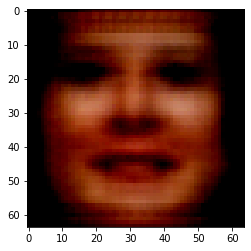

In [54]:
f_no = 1106
family_data = generate_batch([all_families[f_no]])
inp = [family_data[0][0],family_data[0][1]]
inp = tf.cast(inp, tf.float32)

father_inp = inp[0][tf.newaxis,...]
mother_inp = inp[1][tf.newaxis,...]

with tf.device('/cpu:0'):
    gen_output = encoder([father_inp, mother_inp], training=True)
temp = gen_output.numpy()
plt.imshow(np.squeeze(temp))
# print(temp)
print(np.amin(temp))
print(np.amax(temp))

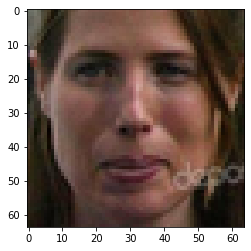

In [55]:
target = family_data[0][3]
plt.imshow(target)

###############################################################################################################################

In [13]:
def disc_downsample_parent_target(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(mean, std_dev) 
  

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer,
                             use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.LeakyReLU(alpha = 0.2))

    return result

In [14]:
def disc_loss(filters, size,apply_batchnorm = False):
    initializer = tf.random_normal_initializer(mean, std_dev)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2D(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                   use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.LeakyReLU(alpha = 0.2))
    
    return result

In [134]:
def Discriminator():

    father = tf.keras.layers.Input(shape=(img_size,img_size,3))
    mother = tf.keras.layers.Input(shape=(img_size,img_size,3))
    target = tf.keras.layers.Input(shape=(img_size,img_size,3))
    
    down_stack_parent_target = [
    disc_downsample_parent_target(32,4,apply_batchnorm=False), #32x32x32
    disc_downsample_parent_target(64,4,apply_batchnorm=True)   #16x16x64
    ]
    
    down_stack_combined =[
    disc_loss(192,4,apply_batchnorm=True),
    disc_loss(256,4,apply_batchnorm=False)
    ]
    
    initializer = tf.random_normal_initializer(mean, sd_random_normal_init)
    last = tf.keras.layers.Conv2D(1, 4, strides=1,padding='same',
                                  kernel_initializer=initializer) # linear layer
    
    
    concat = tf.keras.layers.Concatenate()
    x1 = father
    for down in down_stack_parent_target:
        x1 = down(x1)
    
    x2 = mother
    for down in down_stack_parent_target:
        x2 = down(x2)
        
    x3 = target
    for down in down_stack_parent_target:
        x3 = down(x3)
    
    combined = concat([x1,x2,x3])
    # combined is Batchx16x16x192
    
    x4 = combined
    for down in down_stack_combined:
        x4 = down(x4)
#     print(x4.shape)
    
    output = last(x4) #4X4 
    print(output.shape)

    return tf.keras.Model(inputs=[father,mother,target], outputs=output)

In [135]:
discriminator = Discriminator()

(None, 4, 4, 1)


In [17]:
# family_data = generate_image(all_families[126])
# p1 = tf.cast(family_data[0], tf.float32)
# p2 = tf.cast(family_data[1], tf.float32)
# c = tf.cast(family_data[2], tf.float32)

# discriminator = Discriminator()
# with tf.device('/cpu:0'):
#     disc_out = discriminator(inputs = [p1,p2,c], training=True)

In [88]:
LAMBDA = 1

In [89]:
def tensor_to_array(tensor1):
    return tensor1.numpy()

In [90]:
def discriminator_loss(disc_real_output, disc_generated_output,b_size):
    real_loss_diff = tf.abs(tf.ones_like(disc_real_output) - disc_real_output)
    real_flatten_diff = tf.reshape(real_loss_diff, (b_size, 4*4*1))
    real_loss_batch = tf.reduce_mean(real_flatten_diff, axis=1)
    real_loss = tf.reduce_mean(real_loss_batch)
    
    gen_loss_diff = tf.abs(tf.zeros_like(disc_generated_output) - disc_generated_output)
    gen_flatten_diff = tf.reshape(gen_loss_diff, (b_size, 4*4*1))
    gen_loss_batch = tf.reduce_mean(gen_flatten_diff, axis=1)
    gen_loss = tf.reduce_mean(gen_loss_batch)

    total_disc_loss = real_loss + gen_loss
    return total_disc_loss

In [92]:
def generator_loss(disc_generated_output, gen_output, target,b_size):
    gen_loss_diff = tf.abs(tf.ones_like(disc_generated_output) - disc_generated_output)
    gen_flatten_diff = tf.reshape(gen_loss_diff, (b_size, 4*4*1))
    gen_loss_batch = tf.reduce_mean(gen_flatten_diff, axis=1)
    gen_loss = tf.reduce_mean(gen_loss_batch)
    
    l1_loss_diff = tf.abs(target - gen_output)
    l1_flatten_diff = tf.reshape(l1_loss_diff, (b_size, img_size*img_size*3))
    l1_loss_batch = tf.reduce_mean(l1_flatten_diff, axis=1)
    l1_loss = tf.reduce_mean(l1_loss_batch)
 
    total_gen_loss = gen_loss + LAMBDA * l1_loss  
#     print("Reconstruction loss: {}, GAN loss: {}".format(l1_loss, gen_loss))
    return total_gen_loss

In [93]:
generator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=b1 ,beta_2 = b2)
discriminator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=b1, beta_2 = b2)

In [94]:
def train_step(father_batch, mother_batch, target_batch,b_size):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        gen_outputs = encoder([father_batch, mother_batch], training=True)
#         print("Generated outputs",gen_outputs.shape)
        
        disc_real_output = discriminator([father_batch, mother_batch, target_batch], training=True)
#         print("disc_real_output ", disc_real_output.shape)
        
        disc_generated_output = discriminator([father_batch, mother_batch, gen_outputs], training=True)
#         print("disc_generated_output ", disc_generated_output.shape)
        
        gen_loss =  generator_loss(disc_generated_output, gen_outputs, target_batch,b_size)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output,b_size)
    
        
    print("GEN_LOSS",tensor_to_array(gen_loss))
    print("DISC_LOSS",tensor_to_array(disc_loss))

    generator_gradients = gen_tape.gradient(gen_loss,encoder.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,encoder.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))

In [95]:
def fit(train_ds, epochs, test_ds,batch):
    for epoch in range(epochs):
        print("______________________________EPOCH %d_______________________________"%(epoch))
        start = time.time()
        for i in range(len(train_ds)//batch):
            batch_data = np.asarray(generate_batch(train_ds[i*batch:(i+1)*batch]))
            batch_data = batch_data / 255 * 2 -1
            
            print("Generated batch", batch_data.shape)

            X_father_train = tf.convert_to_tensor(batch_data[:,0],dtype =tf.float32)
            X_mother_train = tf.convert_to_tensor(batch_data[:,1],dtype =tf.float32)
#             print("Xtrain",X_train.shape)
#             print("Batch converted to tensor")

            Y_train = tf.convert_to_tensor(batch_data[:,3],dtype =tf.float32)
            train_step(X_father_train, X_mother_train, Y_train, batch)
            print("Trained for batch %d/%d"%(i+1,(len(train_ds)//batch)))
            
#         family_no = 400
#         family_data = generate_image(all_families[family_no][0], all_families[family_no][1], all_families[family_no][2])
#         inp = [family_data[0],family_data[1]]
#         inp = tf.cast(inp, tf.float32)
#         father_inp = inp[0][tf.newaxis,...]
#         mother_inp = inp[1][tf.newaxis,...]
#         gen_output = encoder([father_inp, mother_inp], training=True)
#         print(tf.reduce_min(gen_output))
#         print(tf.reduce_max(gen_output))
#         plt.figure()
#         plt.imshow(gen_output[0,...])
#         plt.show()
        
    print("______________________________TRAINING COMPLETED_______________________________")
    checkpoint.save(file_prefix = checkpoint_prefix)

In [96]:
concat = tf.keras.layers.Concatenate()

In [97]:
train_dataset = all_families[:-10]
test_dataset = all_families[-10:]
encoder = EncoderNN()
discriminator = Discriminator()

In [98]:
img_size = 64
mean = 0.
std_dev = 0.02
lr = 0.0005
b1 = 0.9
b2 = 0.999
sd_random_normal_init = 0.02

EPOCHS = 5
batch = 25

In [99]:
checkpoint_dir = './checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=encoder,
                                 discriminator=discriminator)

In [100]:
with tf.device('/gpu:0'):
    fit(train_dataset, EPOCHS, test_dataset,batch)

______________________________EPOCH 0_______________________________
Generated batch (25, 4, 64, 64, 3)
GEN_LOSS 1.8714736
DISC_LOSS 1.86838
Trained for batch 1/40
Generated batch (25, 4, 64, 64, 3)
GEN_LOSS 2.4612353
DISC_LOSS 4.9009223
Trained for batch 2/40
Generated batch (25, 4, 64, 64, 3)
GEN_LOSS 1.5188591
DISC_LOSS 3.105586
Trained for batch 3/40
Generated batch (25, 4, 64, 64, 3)
GEN_LOSS 0.97126555
DISC_LOSS 1.2524204
Trained for batch 4/40
Generated batch (25, 4, 64, 64, 3)
GEN_LOSS 1.5256444
DISC_LOSS 1.3195959
Trained for batch 5/40
Generated batch (25, 4, 64, 64, 3)
GEN_LOSS 1.7478199
DISC_LOSS 1.5654196
Trained for batch 6/40
Generated batch (25, 4, 64, 64, 3)
GEN_LOSS 1.615851
DISC_LOSS 1.3376899
Trained for batch 7/40
Generated batch (25, 4, 64, 64, 3)
GEN_LOSS 1.3071386
DISC_LOSS 1.0237919
Trained for batch 8/40
Generated batch (25, 4, 64, 64, 3)
GEN_LOSS 1.033449
DISC_LOSS 0.9461256
Trained for batch 9/40
Generated batch (25, 4, 64, 64, 3)
GEN_LOSS 0.8963132
DISC_LOS

GEN_LOSS 1.2841387
DISC_LOSS 0.49561334
Trained for batch 3/40
Generated batch (25, 4, 64, 64, 3)
GEN_LOSS 1.5364975
DISC_LOSS 0.41733718
Trained for batch 4/40
Generated batch (25, 4, 64, 64, 3)
GEN_LOSS 1.4693565
DISC_LOSS 0.42433232
Trained for batch 5/40
Generated batch (25, 4, 64, 64, 3)
GEN_LOSS 1.1695759
DISC_LOSS 0.5148622
Trained for batch 6/40
Generated batch (25, 4, 64, 64, 3)
GEN_LOSS 1.4071422
DISC_LOSS 0.35677886
Trained for batch 7/40
Generated batch (25, 4, 64, 64, 3)
GEN_LOSS 1.4664278
DISC_LOSS 0.44131666
Trained for batch 8/40
Generated batch (25, 4, 64, 64, 3)
GEN_LOSS 1.2189249
DISC_LOSS 0.44369102
Trained for batch 9/40
Generated batch (25, 4, 64, 64, 3)
GEN_LOSS 1.1590796
DISC_LOSS 0.5533382
Trained for batch 10/40
Generated batch (25, 4, 64, 64, 3)
GEN_LOSS 1.4041679
DISC_LOSS 0.51370907
Trained for batch 11/40
Generated batch (25, 4, 64, 64, 3)
GEN_LOSS 1.3565589
DISC_LOSS 0.48733968
Trained for batch 12/40
Generated batch (25, 4, 64, 64, 3)
GEN_LOSS 1.2861605


GEN_LOSS 1.4466221
DISC_LOSS 0.3695987
Trained for batch 6/40
Generated batch (25, 4, 64, 64, 3)
GEN_LOSS 1.4987152
DISC_LOSS 0.37348965
Trained for batch 7/40
Generated batch (25, 4, 64, 64, 3)
GEN_LOSS 1.5487199
DISC_LOSS 0.42369574
Trained for batch 8/40
Generated batch (25, 4, 64, 64, 3)
GEN_LOSS 1.5518804
DISC_LOSS 0.3809514
Trained for batch 9/40
Generated batch (25, 4, 64, 64, 3)
GEN_LOSS 1.3473154
DISC_LOSS 0.40007833
Trained for batch 10/40
Generated batch (25, 4, 64, 64, 3)
GEN_LOSS 1.3288426
DISC_LOSS 0.42930913
Trained for batch 11/40
Generated batch (25, 4, 64, 64, 3)
GEN_LOSS 1.3517507
DISC_LOSS 0.38130093
Trained for batch 12/40
Generated batch (25, 4, 64, 64, 3)
GEN_LOSS 1.5254881
DISC_LOSS 0.532272
Trained for batch 13/40
Generated batch (25, 4, 64, 64, 3)
GEN_LOSS 1.3758067
DISC_LOSS 0.5294571
Trained for batch 14/40
Generated batch (25, 4, 64, 64, 3)
GEN_LOSS 1.2324489
DISC_LOSS 0.43234694
Trained for batch 15/40
Generated batch (25, 4, 64, 64, 3)
GEN_LOSS 1.1732564


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.99875444
0.961206


TypeError: bad operand type for unary +: 'NoneType'

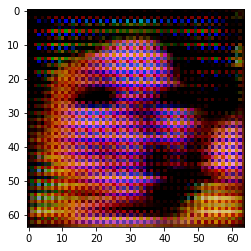

In [101]:
family_no = 1011
family_data = generate_image(all_families[family_no][0], all_families[family_no][1], all_families[family_no][2])
inp = [family_data[0],family_data[1]]
inp = tf.cast(inp, tf.float32)
father_inp = inp[0][tf.newaxis,...]
mother_inp = inp[1][tf.newaxis,...]
with tf.device('/gpu:0'):
    gen_output = encoder([father_inp, mother_inp], training=True)
temp = gen_output.numpy()
plt.imshow(np.squeeze(temp))
print(np.amin(temp))
+print(np.amax(temp))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.99007344
0.960232


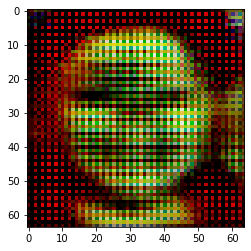

In [54]:
family_no = 1011
family_data = generate_image(all_families[family_no][0], all_families[family_no][1], all_families[family_no][2])
inp = [family_data[0],family_data[1]]
inp = tf.cast(inp, tf.float32)
father_inp = inp[0][tf.newaxis,...]
mother_inp = inp[1][tf.newaxis,...]
with tf.device('/gpu:0'):
    gen_output = encoder([father_inp, mother_inp], training=True)
temp = gen_output.numpy()
plt.imshow(np.squeeze(temp))
print(np.amin(temp))
print(np.amax(temp))